In [5]:
    ## Training data:  with Inception V3 model to increase the accuracy of the model.

In [ ]:
## We will use a different dataset [3] this time, the one which contains outdoor as well as indoor fire images. I have trained our previous CNN model in this dataset and the result was that it overfitted, as it could not handle this comparatively larger dataset and learn complex features from the images.

## Let’s start with creating the ImageDataGenerator for our customized InceptionV3. The dataset contains 3 classes but for this article, we will only use 2 classes. It contains 1800 images for training and 200 images for validation. 

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import shutil
TRAINING_DIR = "/content/FIRE-SMOKE-DATASET/Train"

training_datagen = ImageDataGenerator(brightness_range=[0.5, 1.5],rescale=1./255,zoom_range=0.15,horizontal_flip=True,brightness_range=[0.5, 1.5],height_shift_range=0.2,width_shift_range=0.2,fill_mode='nearest'
																			zoom_range=0.15,
																			horizontal_flip=True,
                                      fill_mode='nearest')

VALIDATION_DIR = "/content/FIRE-SMOKE-DATASET/Test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	shuffle = True,
	class_mode='categorical',
  batch_size = 128
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
	shuffle = True,
  batch_size= 14
)

Found 1808 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [1]:
## Let’s import our InceptionV3 model from the Keras API. We will add our layers at the top of the InceptionV3 model as shown below. We will add a global spatial average pooling layer followed by 2 dense layers and 2 dropout layers to ensure that our model does not overfit. At last, we will add a softmax activated dense layer for 2 classes.

# Next, we will first train only the layers that we added and are randomly initialized. We will use RMSprop as an optimizer here.



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.1099 and logs.get('loss')<=0.1099):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks]
)

Epoch 1/20
14/14 [==============================] - 21s 1s/step - loss: 7.5593 - acc: 0.7696 - val_loss: 0.1244 - val_acc: 0.9541
Epoch 2/20
14/14 [==============================] - 21s 1s/step - loss: 0.1125 - acc: 0.9571 - val_loss: 0.1134 - val_acc: 0.9541
Epoch 3/20
14/14 [==============================] - 21s 1s/step - loss: 0.2159 - acc: 0.9381 - val_loss: 0.1518 - val_acc: 0.9592
Epoch 4/20
14/14 [==============================] - 21s 1s/step - loss: 0.5991 - acc: 0.9155 - val_loss: 0.3868 - val_acc: 0.8316
Epoch 5/20
14/14 [==============================] - 21s 1s/step - loss: 0.1680 - acc: 0.9452 - val_loss: 0.5727 - val_acc: 0.8571
Epoch 6/20
14/14 [==============================] - 21s 1s/step - loss: 0.1073 - acc: 0.9583 - val_loss: 1.3767 - val_acc: 0.7857
Epoch 7/20
14/14 [==============================] - 21s 2s/step - loss: 0.2552 - acc: 0.9256 - val_loss: 0.1011 - val_acc: 0.9592
Epoch 8/20
14/14 [==============================] - 21s 1s/step - loss: 0.0424 - acc: 0.98

In [2]:
## After training our top layers for 20 epochs, we will freeze the first 249 layers of the models and train the rest i.e the top 2 inception blocks. Here, we will use SGD as an optimizer with a learning rate of 0.0001.



In [ ]:

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.1099 and logs.get('loss')<=0.1099):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks]
)
print(len(base_model.layers))

Epoch 1/10
14/14 [==============================] - 22s 2s/step - loss: 0.3753 - acc: 0.8482 - val_loss: 0.1260 - val_acc: 0.9643
Epoch 2/10
14/14 [==============================] - 21s 1s/step - loss: 0.2742 - acc: 0.8821 - val_loss: 0.1200 - val_acc: 0.9643
Epoch 3/10
14/14 [==============================] - 21s 2s/step - loss: 0.1847 - acc: 0.9190 - val_loss: 0.1180 - val_acc: 0.9643
Epoch 4/10
14/14 [==============================] - 22s 2s/step - loss: 0.1505 - acc: 0.9321 - val_loss: 0.1174 - val_acc: 0.9592
Epoch 5/10
14/14 [==============================] - 21s 2s/step - loss: 0.1281 - acc: 0.9458 - val_loss: 0.1172 - val_acc: 0.9643
Epoch 6/10
14/14 [==============================] - 21s 1s/step - loss: 0.1105 - acc: 0.9565 - val_loss: 0.1118 - val_acc: 0.9694
Epoch 7/10
14/14 [==============================] - 22s 2s/step - loss: 0.0788 - acc: 0.9768 - val_loss: 0.1146 - val_acc: 0.9643
Epoch 8/10
14/14 [==============================] - 21s 1s/step - loss: 0.0778 - acc: 0.97

In [3]:
## After training for 10 epochs, we get a training accuracy of 98.04 and a validation accuracy of 96.43. The training and validation losses are 0.063 and 0.118 respectively.

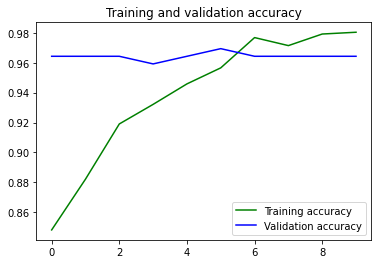

<Figure size 432x288 with 0 Axes>

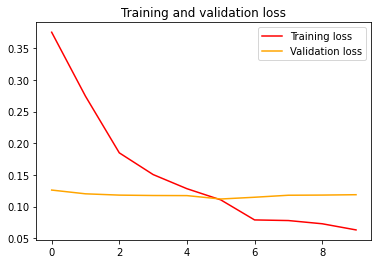

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

In [4]:
model.save("firemodel.h5")


NameError: name 'model' is not defined